In [3]:
import numpy as np
import math
def dot(vA, vB):
    return vA[0]*vB[0]+vA[1]*vB[1]

def joint_similarity(joint_x,joint_y):    
    lambda_ang = -5
    lambda_lr  = -2
    #joint_x
    x_coords_x = [x[0] for x in joint_x]
    y_coords_x = [y[1] for y in joint_x] 
    
    #считаем длины сегментов joint_x 
    left_length_x = ((x_coords_x[1] - x_coords_x[0])**2 + (y_coords_x[1] - y_coords_x[0])**2)**0.5
    right_lentgh_x = ((x_coords_x[1] - x_coords_x[2])**2 + (y_coords_x[1] - y_coords_x[2])**2)**0.5
    
    #отношение длин сегментов joint_x
    gamma_x = left_length_x/right_lentgh_x
    
    #угол joint_x
    point_a_x = [x_coords_x[0]-x_coords_x[1], y_coords_x[0]-y_coords_x[1]]
    point_b_x = [x_coords_x[2]-x_coords_x[1], y_coords_x[2]-y_coords_x[1]]
    ang_a_x = np.arctan2(*point_a_x[::-1])
    ang_b_x = np.arctan2(*point_b_x[::-1])
    angle_x = np.rad2deg((ang_b_x - ang_a_x) % (2 * np.pi))*np.pi/180 
    
    #joint_y
    x_coords_y = [x[0] for x in joint_y]
    y_coords_y = [y[1] for y in joint_y] 
    
    #считаем длины сегментов joint_y 
    left_length_y = ((x_coords_y[1] - x_coords_y[0])**2 + (y_coords_y[1] - y_coords_y[0])**2)**0.5
    right_lentgh_y = ((x_coords_y[1] - x_coords_y[2])**2 + (y_coords_y[1] - y_coords_y[2])**2)**0.5
    
    #отношение длин сегментов joint_y
    gamma_y = left_length_y/right_lentgh_y
    
    #угол joint_y
    point_a_y = [x_coords_y[0]-x_coords_y[1], y_coords_y[0]-y_coords_y[1]]
    point_b_y = [x_coords_y[2]-x_coords_y[1], y_coords_y[2]-y_coords_y[1]]
    ang_a_y = np.arctan2(*point_a_y[::-1])
    ang_b_y = np.arctan2(*point_b_y[::-1])
    angle_y = np.rad2deg((ang_b_y - ang_a_y) % (2 * np.pi))*np.pi/180 
    segment_length_ratio = math.exp(lambda_lr * (1-min(gamma_x/gamma_y, gamma_y/gamma_x)))
    segment_angle_ratio = math.exp(lambda_ang * abs(angle_x-angle_y))
    return segment_length_ratio * segment_angle_ratio

#функция, округляющая с необходимой точностью chain, но она оказалась не нужна ):
def to_corr_chain(chain): 
    
    #делаем loop для chain, добавляя в конец первую точку, а в начало последнюю
    loop_chain=[]
    loop_chain.append(chain[len(chain)-1])
    for j in range(len(chain)):
        loop_chain.append(chain[j])
    loop_chain.append(chain[0])
    x_coords = [x[0] for x in loop_chain]
    y_coords = [y[1] for y in loop_chain] 
    
    lengths_ratios=[]
    angles=[]
    
    #считаем углы джоинтов и отношение длин сегментов, теперь каждый джоинт - это пара (отношение длинн, угол)
    for j in range(len(loop_chain)-2):
        
        left_length = ((x_coords[j] - x_coords[j+1])**2 + (y_coords[j] - y_coords[j+1])**2)**0.5
        right_lentgh = ((x_coords[j+2] - x_coords[j+1])**2 + (y_coords[j+2] - y_coords[j+1])**2)**0.5        
        gamma_x = left_length/right_lentgh
        lengths_ratios.append(left_length/right_lentgh) 
            
        point_a = [x_coords[j]-x_coords[j+1], y_coords[j]-y_coords[j+1]]
        point_b = [x_coords[j+2]-x_coords[j+1], y_coords[j+2]-y_coords[j+1]]
        ang_a = np.arctan2(point_a[1],point_a[0])
        ang_b = np.arctan2(point_b[1], point_b[0])
        angle = np.rad2deg((ang_b - ang_a) % (2 * np.pi))
        angles.append(angle)

    #chain_pairs = np.column_stack((lengths_ratios,angles))
    #print angles 
    #print lengths_ratios
#каждый chain теперь это последовательность пар гамм(отношение длин сегментов джоинта) и тет(угол джоинта),
#для того чтобы был joint_match нам нужно переделать переделать отношения длин, 
#которые в принципе вещественные -> в натуральные, а углы каждый из которых от [0,2*pi] в целые 
#в итоге с необходимой точностью джоинт [1.0, 154.45] и джоинт [1.1, 150.789] перейдут, например в джоинт [30, 78] 
    
    
#следующий цикл с необходимой точностью ставит в соответствие действительному числу натуральное(число ноль пусть тоже натуральное). 
#например с точностью 0.5 числа 0.51 0.9, 0.(98) - станут равными единице, 0.49 - станет нулем. 
   
    accur_angles=[] #-массив округленных с необходимой точностью значений углов(тет)
    accur_lengths_ratios=[] #-массив округленных с необходимой точностью гамм
    for j in range(len(chain)): 
        angle_accuracy = 0.1
        gamma_accuracy = 0.1
        accur_angles.append(int(angles[j]/angle_accuracy)) 
        accur_lengths_ratios.append(int(lengths_ratios[j]/gamma_accuracy))
        accur_chain_pairs = np.column_stack((accur_lengths_ratios,accur_angles))
    #print accur_angles 
    #print accur_lengths_ratios
    return accur_chain_pairs
    
#необходимо создать три матрицы:
# 1) матрицу "сходства"(sim_matrix) где ячейка [i,j] будет соответстовать значению сходства(S_jnt) между i-ым и j-ым джоинтами 
# 2) матрицу "штрафов"(pen_matrix) где ячейка [i, j] будет соответсвовать значению штрафа в случае skipping 
# 3) матрицу Smith-Waterman(S_W_matrix) - матрица, получаемая из двух предыдущих матриц 


def sim_matrix(chain1, chain2):
#в этой функции необходимо считать similarity между каждым джоинтом по принципу "каждый с каждым",
#для этого воспользуемся функцией joint_similarity(J_x,J_y). Ее аргументами являются "тройки" пар, поэтому
#разобьем каждый из chain на последовательные тройки пар с интервалом в одну пару. 
#например если chain - [(1,1),(2,2),(3,3)] - то получим массив из троек - ([[(1,1),(2,2),(3,3)],[(2,2),(3,3),(1,1)]),[]
    
    #looping chain1
    loop_chain1=[]
    loop_chain1.append(chain1[len(chain1)-1])
    for j in range(len(chain1)):
        loop_chain1.append(chain1[j])
    loop_chain1.append(chain1[0])
    
    #массив джоинтов у chain1
    seq_of_joints1 = []
    for j in range(len(loop_chain1)-2):
        seq_of_joints1.append((loop_chain1[j], loop_chain1[j+1],loop_chain1[j+2]))
    
    #looping chain1
    loop_chain2=[]
    loop_chain2.append(chain2[len(chain2)-1])
    for j in range(len(chain2)):
        loop_chain2.append(chain2[j])
    loop_chain2.append(chain2[0])
    
    #массив джоинтов у chain2
    seq_of_joints2 = []
    for j in range(len(loop_chain2)-2):
        seq_of_joints2.append((loop_chain2[j], loop_chain2[j+1],loop_chain2[j+2]))
    
    H = np.zeros((len(chain1) + 1, len(chain2) + 1))
    
    for i in range(len(chain1)):
        for j in range(len(chain2)):
            H[i+1,j+1]=joint_similarity(seq_of_joints1[i], seq_of_joints2[j])
    #print H, "sim_matrix !"
    return H 

#матрица штрафов для chain, пусть lambda_skc = 1
def pen_matrix(chain):
    lambda_skc = 1.0 #чувствительность от потери джоинта в длинах его сегмента
    loop_chain=[]
    loop_chain.append(chain[len(chain)-1])
    for j in range(len(chain)):
        loop_chain.append(chain[j])
    loop_chain.append(chain[0])
    x_coords = [x[0] for x in loop_chain]
    y_coords = [y[1] for y in loop_chain] 
    
    lengths_ratios=[]
    angles=[]
    penalties = []
    for j in range(len(loop_chain)-2):
        left_length = ((x_coords[j] - x_coords[j+1])**2 + (y_coords[j] - y_coords[j+1])**2)**0.5
        right_lentgh = ((x_coords[j+2] - x_coords[j+1])**2 + (y_coords[j+2] - y_coords[j+1])**2)**0.5        
        point_a = [x_coords[j]-x_coords[j+1], y_coords[j]-y_coords[j+1]]
        point_b = [x_coords[j+2]-x_coords[j+1], y_coords[j+2]-y_coords[j+1]]
        ang_a = np.arctan2(point_a[1],point_a[0])
        ang_b = np.arctan2(point_b[1], point_b[0])
        angle = np.rad2deg((ang_b - ang_a) % (2 * np.pi))
        pen = 1 - math.exp(-abs(np.pi - angle)) + lambda_skc*(left_length+right_lentgh)/2
        penalties.append(pen)
    
    #print "penalties", penalties 
    
    return penalties
    
def chain_matching_score(chain1, chain2): 
        H = np.zeros((len(chain1) + 1, len(chain2) + 1))
        #corr_chain1 = to_corr_chain(chain1)
        #corr_chain2 = to_corr_chain(chain2)
        s_matrix  = sim_matrix(chain1, chain2)
        
        p_matrix1 = pen_matrix(chain1)
        p_matrix2 = pen_matrix(chain2)
        
        max_score = 0 
        max_pos   = None
        numb_matches = 1
        for i in range(len(chain1)):
            for j in range(len(chain2)):
                H[i+1,j+1] = max(H[i,j]+s_matrix[i+1,j+1],H[i,j+1]- 0.07*p_matrix1[i],H[i+1,j]- 0.07*p_matrix2[j])
                #print "H[i-1,j-1]=", H[i,j],'!',"s_matrix[i+1,j+1]=", s_matrix[i+1,j+1], "!"
                #candidates_to = np.asarray([H[i,j]+s_matrix[i+1,j+1],H[i,j+1]- p_matrix1[i],H[i+1,j]- p_matrix2[j]])
                #print "candidates_to", candidates_to,'!', "H[i+1,j+1]", H[i+1,j+1],'!'   
                if  H[i+1,j+1] > max_score:
                    max_score = H[i+1,j+1]
                    max_pos   = (i+1, j+1)
        #print chain_matching_score, "score", H 
        #traceback
        chains_similarity = max_score
        next_value = 0
        candidates=[]
        #i=0
        #j=0
        while True:   
            next_value = max(H[max_pos[0], max_pos[1]-1], H[max_pos[0]-1, max_pos[1]-1], H[max_pos[0]-1, max_pos[1]])
            candidates = np.asarray([H[max_pos[0], max_pos[1]-1], H[max_pos[0]-1, max_pos[1]-1], H[max_pos[0]-1, max_pos[1]]])
            
            #print "candidates_for_back", candidates,'!', "next_value",next_value,'!'
            
            if candidates.argmax() == 0:
                max_pos = [max_pos[0], max_pos[1]-1]
                #print "skip"
            if candidates.argmax() == 1:
                max_pos = [max_pos[0]-1, max_pos[1]-1]
                
                #print "match!"
                
                numb_matches = numb_matches + 1
            if candidates.argmax() == 2:
                max_pos = [max_pos[0]-1, max_pos[1]]
                #print "skip"
            
            if max_pos[1] == 0:
                break
            if max_pos[0] == 0:
                break
            max_length=max(len(chain1),len(chain2))
            #print "max_length", max_length, "!!!"
            #print "новая max_pos", max_pos, "max_pos[0]-", max_pos[0],'max_pos[1]-', max_pos[1]
            chains_similarity = chains_similarity + next_value 
            #print "chains_similarity", chains_similarity, "!"
        chains_similarity = chains_similarity/(max_length*(max_length+1)/2.0)
        return chains_similarity, numb_matches
        
def sum_angles_of(points):
    x_coords = [x[0] for x in points]
    y_coords = [y[1] for y in points]    
    chain_len = len(points)
    centroid_x = sum(x_coords)/chain_len #нашли первую координату барицентра
    centroid_y = sum(y_coords)/chain_len #вторую
    tensor=[]
    sum_angles = 0
    for p in points:
        t = [(centroid_x-p[0]), (centroid_y-p[1])]   
        tensor.append(t)
    
    for t in range(len(tensor)-1):
        dot_prod = dot(tensor[t], tensor[t+1])
        
    #Считаем длины сегментов
        length_seg_1 = dot(tensor[t], tensor[t])**0.5
        length_seg_2 = dot(tensor[t+1], tensor[t+1])**0.5
    #Находим косинусы между сегментами
        cos_ = dot_prod/length_seg_1/length_seg_2
    #Находим угол
        angle = math.acos(dot_prod/length_seg_1/length_seg_2)
        sum_angles = sum_angles + angle
    return sum_angles

def Global_Angle_Consistency(chain1, chain2): 
    lambda_ac = 0.1
    sum_angles1 = sum_angles_of(chain1)
    #print "sum_angles1=", sum_angles1, "!"
    sum_angles2 = sum_angles_of(chain2)
    #print "sum_angles2=", sum_angles2, "!"
    number_of_matches = chain_matching_score(chain1, chain2)[1]
    #print "number_of_matches=", number_of_matches, "!"
    angle_consistency = math.exp(-lambda_ac*(sum_angles1 - sum_angles2)/number_of_matches)
    return angle_consistency
    
def dist(chain1, chain2):
    distance = Global_Angle_Consistency(chain1, chain2) * chain_matching_score(chain1, chain2)[0]
    return distance


In [4]:
to_corr_chain([(0.0,1.0),(1.0,0.0),(1.0,1.0)])

array([[   7, 3150],
       [  14, 3150],
       [  10, 2700]])

In [5]:
sim_matrix([(0.0,0.0),(1.0,0.0),(1.0,1.0)],[(0.0,0.0),(1.0,1.0),(0.0,1.0)])

array([[ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.36787944,  1.        ,  0.01096796],
       [ 0.        ,  0.01096796,  0.01096796,  1.        ],
       [ 0.        ,  1.        ,  0.36787944,  0.01096796]])

In [6]:
pen_matrix([(0.0,0.0),(1.0,0.0),(1.0,1.0)])

[2.2071067811865475, 2.0, 2.2071067811865475]

In [7]:
chain_matching_score([(12.23,14.43),(11.23214,345.355),(234.0,109.0)],[(3.0,1.0),(32.0,90.0),(21.0,44.0)])

(0.0076253968590708271, 2)

In [8]:
Global_Angle_Consistency([(0.0,0.0),(1.0,1.0),(0.0,1.0)], [(0.0,0.0),(1.0,1.0),(0.0,1.0)])

1.0

In [9]:
dist([(0.0,0.0),(1.0,1.0),(0.0,1.0)], [(0.0,0.0),(1.0,1.0),(0.0,1.0)])

1.0

In [10]:
dist([(1.0,1.0),(0.0,2.0),(9.0,4.0)], [(1.0,8.0),(0.0,6.0),(9.0,6.0)])

8.7589678050317677e-07

In [11]:
dist([(1.0,4.0),(0.0,2.0),(9.0,5.0)], [(1.0,8.0),(0.0,6.0),(9.0,6.0)])

0.24953533348172843

In [12]:
dist([(2.0,3.0),(1.0,2.0),(9.0,5.0)], [(1.0,8.0),(0.0,6.0),(9.0,6.0)])

0.086876136758746031

In [13]:
dist([(1.0,1.0),(0.0,2.0),(9.0,4.0)], [(1.0,8.0),(0.0,6.0),(9.0,6.0)])

8.7589678050317677e-07

In [14]:
dist([(1.0,8.0),(0.0,6.0),(9.0,8.0)], [(1.0,8.0),(0.0,6.0),(9.0,8.0)])

1.0

In [15]:
dist([(38.0,82.0),(25.0,7.0),(64.0,41.0)], [(38.1,82.1),(25.1,7.1),(64.1,41.1)])

1.0

In [16]:
#инвариантность к паралельному переносу. пример выше

In [17]:
#dist([(-4.5,4.0),(-1.0,4.0),(-3.5,2.5),(-2.5,3.5),(-1.0,2.5),(-2.5,2.15),(-2.5,3.0),(1.5,3.5),(4.5,3.5),(1.5,2.5),(2.5,3.5),(3.5,2.5),(2.5,2.35),(2.5,2.80),(0.0,0.0),(-0.5,-0.5),(1.0,-0.5),(-1.5,-2.8),(-0.5,-2.15),(1.0,-2.15),(2.0,-2.5),(0.0,-3.5),(0.0,-2.7)],[(-4.0,4.0),(-1.5,3.6),(-3.5,2.5),(-2.5,2.9),(-1.3,2.3),(-2.5,1.9),(-2.5,2.5),(2.0,3.8),(4.3,2.8),(1.4,2.3),(2.5,3.0),(3.5,2.3),(2.5,1.6),(2.5,2.5),(0.0,0.0),(-0.8,-0.8),(0.7,-0.7),(-1.9,-2.6),(-0.7,-2.1),(0.6,-2.1),(1.9,-2.5),(0.0,-3.7),(0.0,-2.8)])

In [18]:
#import csv
#3,4
#high_low = []
#with open('prices.csv', "w") as csvfile:
#    columns = ["high", "low"]
#    writer = csv.reader(csvfile, fieldnames=columns)
#    list(writer)
   


In [19]:
from numpy import genfromtxt
my_data = genfromtxt('prices.csv', delimiter=',')

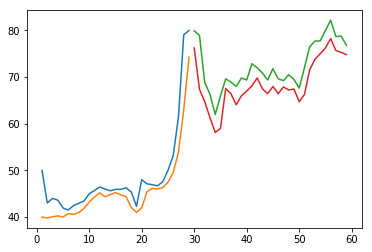

In [20]:
import numpy as np
import matplotlib.pyplot as plt

from numpy import genfromtxt
my_data = genfromtxt('prices.csv', delimiter=',')
#делаем первый chain data_1
minim_1 = []
maxim_1 =[]
for row in my_data:
    minim_1.append(row[3])
    maxim_1.append(row[4])
#del(minim_1[0])
#del(maxim_1[0])

month_minim_1 = []
month_maxim_1 = []
timestamps_1  = []


for min_price_1 in range(0,30): 
    month_minim_1.append(minim_1[min_price_1])

for max_price_1 in range(0,30): 
    month_maxim_1.append(maxim_1[max_price_1])


month_maxim_1_back = month_maxim_1[::-1]

for timestamp in range (0,30):
    timestamps_1.append(timestamp)

timestamps_back_1 = timestamps_1[::-1]


min_time_1 = np.column_stack([month_minim_1,timestamps_1])
max_time_1 = np.column_stack([month_maxim_1_back,timestamps_back_1]) 


min_time_1 = list(min_time_1)

max_time_1 = list(max_time_1)

data_1 = np.vstack((min_time_1,max_time_1))



#делаем второй chain data_2
minim_2 = []
maxim_2 =[]
for row in my_data:
    minim_2.append(row[3])
    maxim_2.append(row[4])


month_minim_2 = []
month_maxim_2 = []


for min_price_2 in range(30,60): 
    month_minim_2.append(minim_2[min_price_2])

for max_price_2 in range(30,60): 
    month_maxim_2.append(maxim_2[max_price_2])

month_maxim_2_back = month_maxim_2[::-1]


timestamps_2=[]

for timestamp in range (30,60):
    timestamps_2.append(timestamp)
timestamps_back_2 = timestamps_2[::-1]

min_time_2 = np.column_stack([month_minim_2,timestamps_2])
max_time_2 = np.column_stack([month_maxim_2_back, timestamps_back_2]) 


min_time_2 = list(min_time_2)

max_time_2 = list(max_time_2)

data_2 = np.vstack((min_time_2,max_time_2))


plt.plot(timestamps_1, month_minim_1)
plt.plot(timestamps_back_1, month_maxim_1_back)
plt.plot(timestamps_2, month_minim_2)
plt.plot(timestamps_back_2, month_maxim_2_back)
plt.show()


In [26]:
dist(data_1,data_2)
print data_1 

[[ 78.94  30.  ]
 [ 68.88  31.  ]
 [ 66.31  32.  ]
 [ 62.    33.  ]
 [ 65.94  34.  ]
 [ 69.63  35.  ]
 [ 68.94  36.  ]
 [ 68.    37.  ]
 [ 69.81  38.  ]
 [ 69.38  39.  ]
 [ 72.88  40.  ]
 [ 72.    41.  ]
 [ 70.88  42.  ]
 [ 69.38  43.  ]
 [ 71.81  44.  ]
 [ 69.63  45.  ]
 [ 69.25  46.  ]
 [ 70.5   47.  ]
 [ 69.5   48.  ]
 [ 67.63  49.  ]
 [ 72.    50.  ]
 [ 76.5   51.  ]
 [ 77.75  52.  ]
 [ 77.75  53.  ]
 [ 80.    54.  ]
 [ 82.19  55.  ]
 [ 78.69  56.  ]
 [ 78.81  57.  ]
 [ 76.81  58.  ]
 [ 76.94  59.  ]
 [ 74.81  59.  ]
 [ 74.81  58.  ]
 [ 75.31  57.  ]
 [ 75.69  56.  ]
 [ 78.25  55.  ]
 [ 76.25  54.  ]
 [ 75.    53.  ]
 [ 73.81  52.  ]
 [ 71.56  51.  ]
 [ 66.25  50.  ]
 [ 64.75  49.  ]
 [ 67.44  48.  ]
 [ 67.25  47.  ]
 [ 67.88  46.  ]
 [ 66.44  45.  ]
 [ 68.    44.  ]
 [ 66.44  43.  ]
 [ 67.5   42.  ]
 [ 69.81  41.  ]
 [ 68.13  40.  ]
 [ 67.    39.  ]
 [ 66.    38.  ]
 [ 64.06  37.  ]
 [ 66.44  36.  ]
 [ 67.56  35.  ]
 [ 59.    34.  ]
 [ 58.13  33.  ]
 [ 61.31  32.  ]
 [ 64.75  31. 

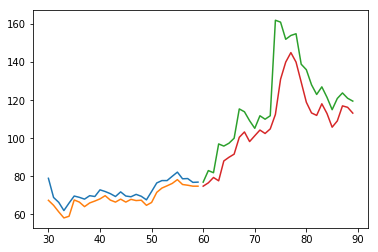

In [28]:
import numpy as np
import matplotlib.pyplot as plt

from numpy import genfromtxt
my_data = genfromtxt('prices.csv', delimiter=',')
#делаем первый chain data_1
minim_1 = []
maxim_1 =[]
for row in my_data:
    minim_1.append(row[3])
    maxim_1.append(row[4])
del(minim_1[0])
del(maxim_1[0])

month_minim_1 = []
month_maxim_1 = []
timestamps_1  = []


for min_price_1 in range(30,60): 
    month_minim_1.append(minim_1[min_price_1])

for max_price_1 in range(30,60): 
    month_maxim_1.append(maxim_1[max_price_1])


month_maxim_1_back =month_maxim_1[::-1]

for timestamp in range (30,60):
    timestamps_1.append(timestamp)

timestamps_back_1 = timestamps_1[::-1]

#print "timestamps", timestamps, "timestamps_back", timestamps_back

 
#max_not_back = np.column_stack([month_maxim_1,timestamps])
#print "max_not_back", max_not_back


min_time_1 = np.column_stack([month_minim_1,timestamps_1])
max_time_1 = np.column_stack([month_maxim_1_back,timestamps_back_1]) 

#print "max_back", max_time_1

min_time_1 = list(min_time_1)

max_time_1 = list(max_time_1)

data_1 = np.vstack((min_time_1,max_time_1))

#print "data_1",data_1






#делаем второй chain data_2
minim_2 = []
maxim_2 =[]
for row in my_data:
    minim_2.append(row[3])
    maxim_2.append(row[4])


month_minim_2 = []
month_maxim_2 = []


for min_price_2 in range(60,90): 
    month_minim_2.append(minim_2[min_price_2])

for max_price_2 in range(60,90): 
    month_maxim_2.append(maxim_2[max_price_2])

month_maxim_2_back = month_maxim_2[::-1]

#print "month_maxim_2_back",month_maxim_2_back
#print "timestamps_back",timestamps_back

timestamps_2=[]
#print "month_minim_2", month_minim_2
#print "timestamps_2",timestamps_2
for timestamp in range (60,90):
    timestamps_2.append(timestamp)
timestamps_back_2 = timestamps_2[::-1]

min_time_2 = np.column_stack([month_minim_2,timestamps_2])
max_time_2 = np.column_stack([month_maxim_2_back, timestamps_back_2]) 


min_time_2 = list(min_time_2)

max_time_2 = list(max_time_2)

data_2 = np.vstack((min_time_2,max_time_2))

#print "timestamps_1",timestamps_1
#print "timestamps_back_1", timestamps_back_1
#print "timestamps_2",timestamps_2 
#print "timestamps_back_2",timestamps_back_2




#print "month_mimin_1", month_minim_1 
#print "data_1", data_1
#print "data_2", data_2


plt.plot(timestamps_1, month_minim_1)
plt.plot(timestamps_back_1, month_maxim_1_back)
plt.plot(timestamps_2, month_minim_2)
plt.plot(timestamps_back_2, month_maxim_2_back)

#plt.plot(timestamps_1,data_1[1])
plt.show()

In [29]:
dist(data_1,data_2)
print data_1

[[ 78.94  30.  ]
 [ 68.88  31.  ]
 [ 66.31  32.  ]
 [ 62.    33.  ]
 [ 65.94  34.  ]
 [ 69.63  35.  ]
 [ 68.94  36.  ]
 [ 68.    37.  ]
 [ 69.81  38.  ]
 [ 69.38  39.  ]
 [ 72.88  40.  ]
 [ 72.    41.  ]
 [ 70.88  42.  ]
 [ 69.38  43.  ]
 [ 71.81  44.  ]
 [ 69.63  45.  ]
 [ 69.25  46.  ]
 [ 70.5   47.  ]
 [ 69.5   48.  ]
 [ 67.63  49.  ]
 [ 72.    50.  ]
 [ 76.5   51.  ]
 [ 77.75  52.  ]
 [ 77.75  53.  ]
 [ 80.    54.  ]
 [ 82.19  55.  ]
 [ 78.69  56.  ]
 [ 78.81  57.  ]
 [ 76.81  58.  ]
 [ 76.94  59.  ]
 [ 74.81  59.  ]
 [ 74.81  58.  ]
 [ 75.31  57.  ]
 [ 75.69  56.  ]
 [ 78.25  55.  ]
 [ 76.25  54.  ]
 [ 75.    53.  ]
 [ 73.81  52.  ]
 [ 71.56  51.  ]
 [ 66.25  50.  ]
 [ 64.75  49.  ]
 [ 67.44  48.  ]
 [ 67.25  47.  ]
 [ 67.88  46.  ]
 [ 66.44  45.  ]
 [ 68.    44.  ]
 [ 66.44  43.  ]
 [ 67.5   42.  ]
 [ 69.81  41.  ]
 [ 68.13  40.  ]
 [ 67.    39.  ]
 [ 66.    38.  ]
 [ 64.06  37.  ]
 [ 66.44  36.  ]
 [ 67.56  35.  ]
 [ 59.    34.  ]
 [ 58.13  33.  ]
 [ 61.31  32.  ]
 [ 64.75  31. 

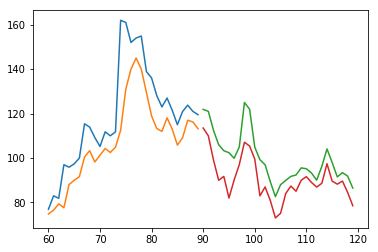

In [236]:
import numpy as np
import matplotlib.pyplot as plt

from numpy import genfromtxt
my_data = genfromtxt('prices.csv', delimiter=',')
#делаем первый chain data_1
minim_1 = []
maxim_1 =[]
for row in my_data:
    minim_1.append(row[3])
    maxim_1.append(row[4])
#del(minim_1[0])
#del(maxim_1[0])

month_minim_1 = []
month_maxim_1 = []
timestamps_1  = []


for min_price_1 in range(60,90): 
    month_minim_1.append(minim_1[min_price_1])

for max_price_1 in range(60,90): 
    month_maxim_1.append(maxim_1[max_price_1])


month_maxim_1_back =month_maxim_1[::-1]

for timestamp in range (60,90):
    timestamps_1.append(timestamp)

timestamps_back_1 = timestamps_1[::-1]

#print "timestamps", timestamps, "timestamps_back", timestamps_back

 
#max_not_back = np.column_stack([month_maxim_1,timestamps])
#print "max_not_back", max_not_back


min_time_1 = np.column_stack([month_minim_1,timestamps_1])
max_time_1 = np.column_stack([month_maxim_1_back,timestamps_back_1]) 

#print "max_back", max_time_1

min_time_1 = list(min_time_1)

max_time_1 = list(max_time_1)

data_1 = np.vstack((min_time_1,max_time_1))

#print "data_1",data_1






#делаем второй chain data_2
minim_2 = []
maxim_2 =[]
for row in my_data:
    minim_2.append(row[3])
    maxim_2.append(row[4])


month_minim_2 = []
month_maxim_2 = []


for min_price_2 in range(90,120): 
    month_minim_2.append(minim_2[min_price_2])

for max_price_2 in range(90,120): 
    month_maxim_2.append(maxim_2[max_price_2])

month_maxim_2_back = month_maxim_2[::-1]

#print "month_maxim_2_back",month_maxim_2_back
#print "timestamps_back",timestamps_back

timestamps_2=[]
#print "month_minim_2", month_minim_2
#print "timestamps_2",timestamps_2
for timestamp in range (90,120):
    timestamps_2.append(timestamp)
timestamps_back_2 = timestamps_2[::-1]

min_time_2 = np.column_stack([month_minim_2,timestamps_2])
max_time_2 = np.column_stack([month_maxim_2_back, timestamps_back_2]) 


min_time_2 = list(min_time_2)

max_time_2 = list(max_time_2)

data_2 = np.vstack((min_time_2,max_time_2))

#print "timestamps_1",timestamps_1
#print "timestamps_back_1", timestamps_back_1
#print "timestamps_2",timestamps_2 
#print "timestamps_back_2",timestamps_back_2




#print "month_mimin_1", month_minim_1 
#print "data_1", data_1
#print "data_2", data_2


plt.plot(timestamps_1, month_minim_1)
plt.plot(timestamps_back_1, month_maxim_1_back)
plt.plot(timestamps_2, month_minim_2)
plt.plot(timestamps_back_2, month_maxim_2_back)

#plt.plot(timestamps_1,data_1[1])
plt.show()

In [39]:
dist(data_1,data_1)

1.0

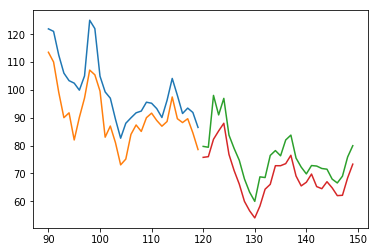

In [31]:
import numpy as np
import matplotlib.pyplot as plt

from numpy import genfromtxt
my_data = genfromtxt('prices.csv', delimiter=',')
#делаем первый chain data_1
minim_1 = []
maxim_1 =[]
for row in my_data:
    minim_1.append(row[3])
    maxim_1.append(row[4])
#del(minim_1[0])
#del(maxim_1[0])

month_minim_1 = []
month_maxim_1 = []
timestamps_1  = []


for min_price_1 in range(90,120): 
    month_minim_1.append(minim_1[min_price_1])

for max_price_1 in range(90,120): 
    month_maxim_1.append(maxim_1[max_price_1])


month_maxim_1_back =month_maxim_1[::-1]

for timestamp in range (90,120):
    timestamps_1.append(timestamp)

timestamps_back_1 = timestamps_1[::-1]

#print "timestamps", timestamps, "timestamps_back", timestamps_back

 
#max_not_back = np.column_stack([month_maxim_1,timestamps])
#print "max_not_back", max_not_back


min_time_1 = np.column_stack([month_minim_1,timestamps_1])
max_time_1 = np.column_stack([month_maxim_1_back,timestamps_back_1]) 

#print "max_back", max_time_1

min_time_1 = list(min_time_1)

max_time_1 = list(max_time_1)

data_1 = np.vstack((min_time_1,max_time_1))

#print "data_1",data_1






#делаем второй chain data_2
minim_2 = []
maxim_2 =[]
for row in my_data:
    minim_2.append(row[3])
    maxim_2.append(row[4])


month_minim_2 = []
month_maxim_2 = []


for min_price_2 in range(120,150): 
    month_minim_2.append(minim_2[min_price_2])

for max_price_2 in range(120,150): 
    month_maxim_2.append(maxim_2[max_price_2])

month_maxim_2_back = month_maxim_2[::-1]

#print "month_maxim_2_back",month_maxim_2_back
#print "timestamps_back",timestamps_back

timestamps_2=[]
#print "month_minim_2", month_minim_2
#print "timestamps_2",timestamps_2
for timestamp in range (120,150):
    timestamps_2.append(timestamp)
timestamps_back_2 = timestamps_2[::-1]

min_time_2 = np.column_stack([month_minim_2,timestamps_2])
max_time_2 = np.column_stack([month_maxim_2_back, timestamps_back_2]) 


min_time_2 = list(min_time_2)

max_time_2 = list(max_time_2)

data_2 = np.vstack((min_time_2,max_time_2))

#print "timestamps_1",timestamps_1
#print "timestamps_back_1", timestamps_back_1
#print "timestamps_2",timestamps_2 
#print "timestamps_back_2",timestamps_back_2




#print "month_mimin_1", month_minim_1 
#print "data_1", data_1
#print "data_2", data_2


plt.plot(timestamps_1, month_minim_1)
plt.plot(timestamps_back_1, month_maxim_1_back)
plt.plot(timestamps_2, month_minim_2)
plt.plot(timestamps_back_2, month_maxim_2_back)

#plt.plot(timestamps_1,data_1[1])
plt.show()

In [32]:
dist(data_1,data_2)

0.10895585737418785

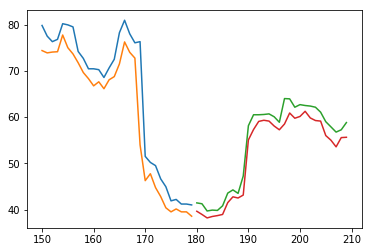

In [38]:
import numpy as np
import matplotlib.pyplot as plt

from numpy import genfromtxt
my_data = genfromtxt('prices.csv', delimiter=',')

#делаем первый chain data_1
minim_1 = []
maxim_1 =[]
for row in my_data:
    minim_1.append(row[3])
    maxim_1.append(row[4])
month_minim_1 = []
month_maxim_1 = []
timestamps_1  = []
for min_price_1 in range(150,180): 
    month_minim_1.append(minim_1[min_price_1])
for max_price_1 in range(150,180): 
    month_maxim_1.append(maxim_1[max_price_1])
month_maxim_1_back =month_maxim_1[::-1]
for timestamp in range (150,180):
    timestamps_1.append(timestamp)
timestamps_back_1 = timestamps_1[::-1]
min_time_1 = np.column_stack([month_minim_1,timestamps_1])
max_time_1 = np.column_stack([month_maxim_1_back,timestamps_back_1]) 
min_time_1 = list(min_time_1)
max_time_1 = list(max_time_1)
data_1 = np.vstack((min_time_1,max_time_1))
#делаем второй chain data_2
minim_2 = []
maxim_2 =[]
for row in my_data:
    minim_2.append(row[3])
    maxim_2.append(row[4])
month_minim_2 = []
month_maxim_2 = []
for min_price_2 in range(180,210): 
    month_minim_2.append(minim_2[min_price_2])
for max_price_2 in range(180,210): 
    month_maxim_2.append(maxim_2[max_price_2])
month_maxim_2_back = month_maxim_2[::-1]
timestamps_2=[]
for timestamp in range (180,210):
    timestamps_2.append(timestamp)
timestamps_back_2 = timestamps_2[::-1]
min_time_2 = np.column_stack([month_minim_2,timestamps_2])
max_time_2 = np.column_stack([month_maxim_2_back, timestamps_back_2]) 
min_time_2 = list(min_time_2)
max_time_2 = list(max_time_2)
data_2 = np.vstack((min_time_2,max_time_2))

plt.plot(timestamps_1, month_minim_1)
plt.plot(timestamps_back_1, month_maxim_1_back)
plt.plot(timestamps_2, month_minim_2)
plt.plot(timestamps_back_2, month_maxim_2_back)

#plt.plot(timestamps_1,data_1[1])
plt.show()



In [36]:
dist(data_1,data_2)

0.096745213584911227

In [11]:
#сохраняем картинку на носитель
import matplotlib.pyplot as plt
fig, ax = plt.subplots( nrows=1, ncols=1 )  # create figure & 1 axis
ax.plot(timestamps_1, month_minim_1)
fig.savefig('/Users/admin/Desktop/database/bar.png')   # save the figure to file
plt.close(fig) 